## Table of Contents

    1. Import libraries and data set
    2. Data wrangling
    3. Decomposition of components
    4. Stationarity test
        a. Dickey-Fuller test
        b. Autocorrelation test
    5. Stationarizing the data

# 01. Import libraries and data set

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm # Import the public access version of statsmodels, a library that handles statistical models
import warnings

# Disable deprecation warnings that could indicate a suspended library or feature
warnings.filterwarnings("ignore")

# Styling option for how plots will appear
plt.style.use('fivethirtyeight')

In [2]:
# Create a path for easier importing
path = r'C:\Users\blim9\Desktop\Career Foundry\Data Immersion\Achievement 6\World Happiness Report'

In [3]:
# Import the data set
df = pd.read_csv(os.path.join (path, '02. Data', 'Prepared Data', 'cleaned_revised_dataset.csv'), index_col = 0)

In [4]:
df.head()

,Country,Region,Continent,Year,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family (Social Support),Health (Life Expectancy),Freedom (Life Choices),Trust (Government Corruption),Generosity (Donations to Charity),Dystopia Residual,Happiness Status
0,Switzerland,Western Europe,Europe,2015,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,Happy country
1,Iceland,Western Europe,Europe,2015,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,Happy country
2,Denmark,Western Europe,Europe,2015,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,Happy country
3,Norway,Western Europe,Europe,2015,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,Happy country
4,Canada,North America,North America,2015,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,Happy country


# 02. Data wrangling

### Since my data set only has five years of data (2015 - 2019), I will be breaking down each year into quarterly months.

In [5]:
# Check how many values are within each year
df.groupby('Year').agg('Happiness Rank').count()

Year
2015    158
2016    157
2017    155
2018    155
2019    156
Name: Happiness Rank, dtype: int64

In [6]:
# For the purpose of this assignment, I am dividing the number of values above by four. Then, each year will have a quarterly
# month associated with it so it's divided into segments.
df.loc[(df['Happiness Rank'] >= 1) & (df['Happiness Rank'] < 40), 'Date'] = df['Year'].astype(str) + '-01-01'
df.loc[(df['Happiness Rank'] >= 40) & (df['Happiness Rank'] < 79), 'Date'] = df['Year'].astype(str) + '-04-01'
df.loc[(df['Happiness Rank'] >= 79) & (df['Happiness Rank'] < 118), 'Date'] = df['Year'].astype(str) + '-07-01'
df.loc[(df['Happiness Rank'] >= 118) & (df['Happiness Rank'] < 159), 'Date'] = df['Year'].astype(str) + '-10-01'

In [7]:
df.head()

,Country,Region,Continent,Year,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family (Social Support),Health (Life Expectancy),Freedom (Life Choices),Trust (Government Corruption),Generosity (Donations to Charity),Dystopia Residual,Happiness Status,Date
0,Switzerland,Western Europe,Europe,2015,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,Happy country,2015-01-01
1,Iceland,Western Europe,Europe,2015,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,Happy country,2015-01-01
2,Denmark,Western Europe,Europe,2015,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,Happy country,2015-01-01
3,Norway,Western Europe,Europe,2015,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,Happy country,2015-01-01
4,Canada,North America,North America,2015,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,Happy country,2015-01-01


In [8]:
# Create a subset of the data using the 'Date' and 'Happiness Score' columns
df_subset = df.groupby('Date').agg({'Happiness Score': ['mean']})

In [9]:
df_subset.head()

,Happiness Score
,mean
Date,
2015-01-01,6.920769
2015-04-01,5.765385
2015-07-01,4.909513
2015-10-01,3.978902
2016-01-01,6.884692


#### I decided to use the mean of the happiness score because each year has an almost identical amount of values. In addition, I know there aren't any outliers that will skew the data points. I compared the values using both the mean and median, and felt that the mean would provide a better depiction over the years.

In [10]:
# Reset the index so the 'Date' column can be used as a filter
df_subset = df_subset.reset_index()

In [11]:
df_subset.head()

,Date,Happiness Score
,,mean
0,2015-01-01,6.920769
1,2015-04-01,5.765385
2,2015-07-01,4.909513
3,2015-10-01,3.978902
4,2016-01-01,6.884692


In [12]:
# Set the "Date" column as the index

from datetime import datetime

df_subset['Quarterly Date'] = pd.to_datetime(df_subset['Date']) # Create a 'Quarterly Date' column from "Date"
df_subset = df_subset.set_index('Quarterly Date') # Set 'Quarterly Date' as the index of the dataframe
df_subset.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
df_subset.head()

,Happiness Score
,mean
Quarterly Date,
2015-01-01,6.920769
2015-04-01,5.765385
2015-07-01,4.909513
2015-10-01,3.978902
2016-01-01,6.884692


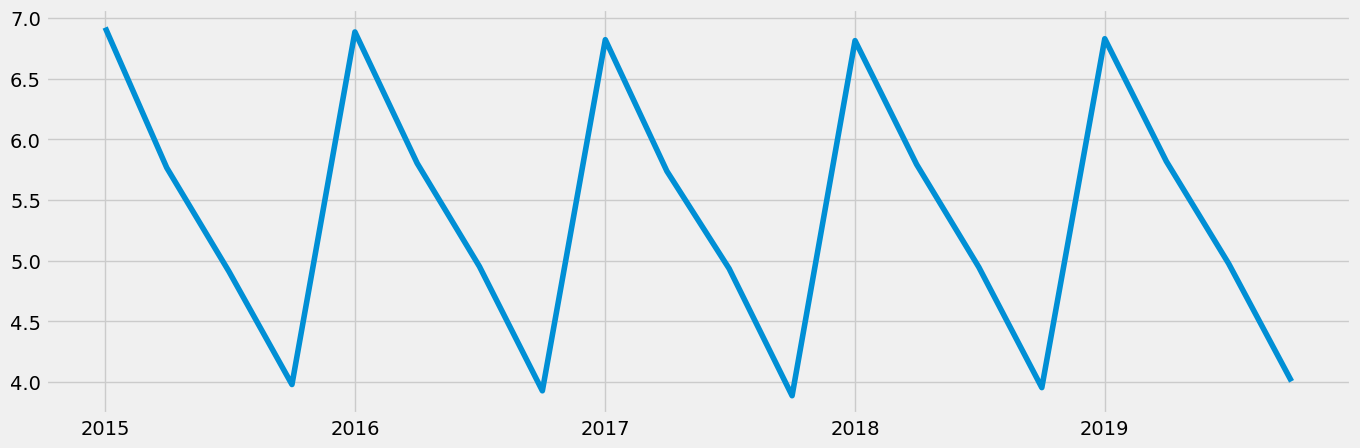

In [13]:
# Create a line chart of the data
plt.figure(figsize = (15,5), dpi = 100)
plt.plot(df_subset)

# 03. Decomposition of components

In [14]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_subset, model='additive')

In [15]:
from pylab import rcParams # This will define a fixed size for all special charts

rcParams['figure.figsize'] = 18, 7

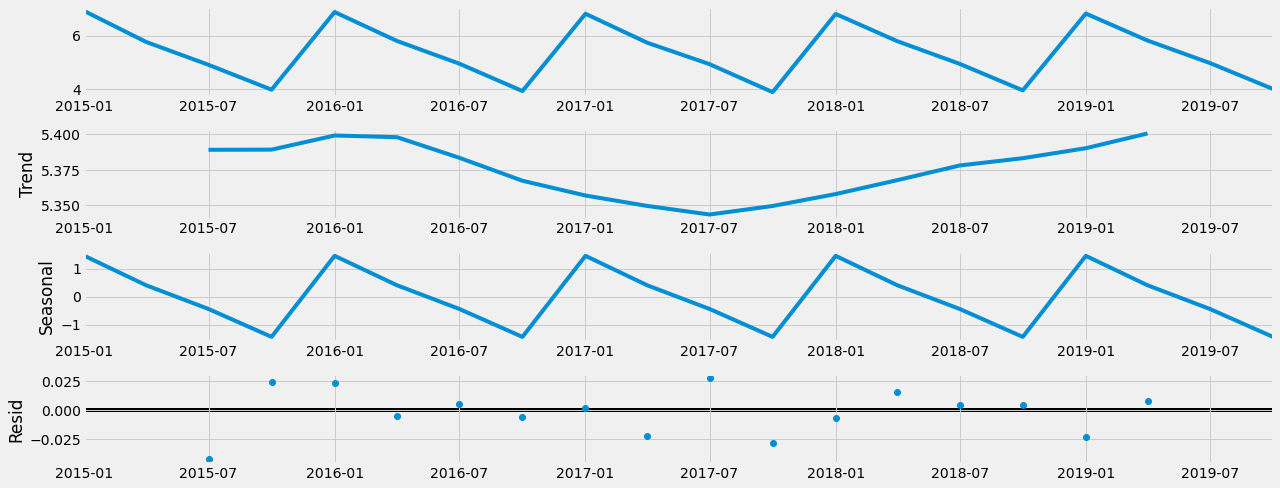

In [16]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Starting from the level, I already knew that the graph would look like this since I'm forcing quarterly dates onto each year. By assigning dates to each year in order of Happiness Rank, it will trend down as the ranks decrease.

#### Looking at the trend, it's not similar to the level because my data has not been smoothed. 

#### In terms of seasonality, similar to the level, because I forcefully segmented the year into four quarters, every year in January (01-01) will be the peak. It then gradually decreases as the year goes by before rising up again.

#### The last component seems to follow a similar trend to the level where it fluctuates up and down due to noise.

# 04. Stationarity test

## 4.1 Dickey-Fuller test

In [18]:
# The adfuller() function will import from the model from statsmodels but running it will only return an array of numbers
# This is why a function that prints the correct output from that array needs to be defined

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_subset['Happiness Score'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.650790
p-value                         0.456628
Number of Lags Used             5.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64


### H0: Presence of a unit root (This means it's non-stationary)
### HA = No unit root (This means it's stationary)

#### The test statistic (-1.650790) is larger than the critical value (5%) which is -3.104184, therefore the null hypothesis cannot be rejected. A unit root does exist making this data non-stationary.

#### The p-value is also 0.456628 which is larger than 0.05 making it not significant.

## 4.2 Autocorrelation test

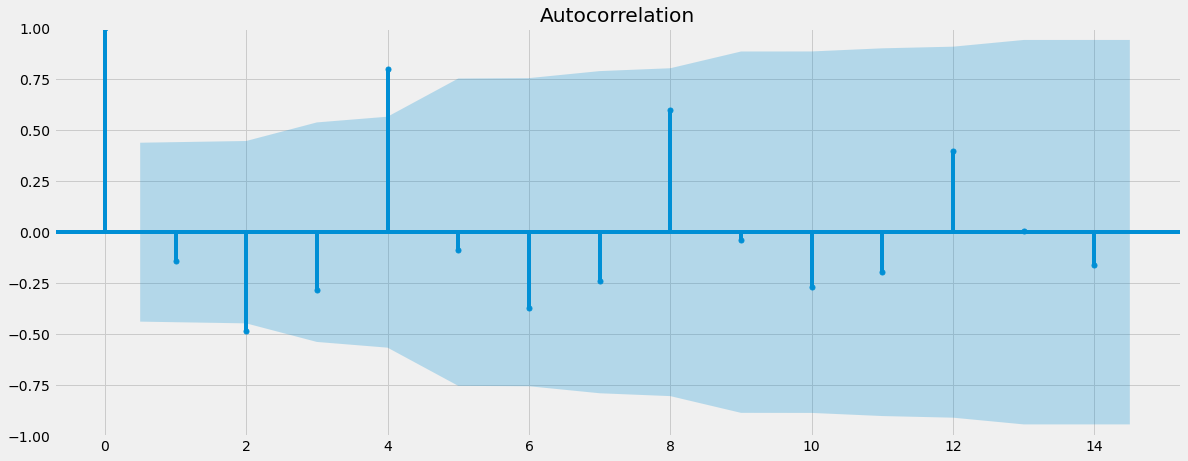

In [19]:
# Check the plot for autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import the autocorrelation and partial correlation plots

plot_acf(df_subset)
plt.show()

#### There are lines that go above the blue edges of the confidence intervals, meaning there are lags significantly correlated with each other. This supports the test-results of the Dickey-Fuller test stating this data is non-stationary.

# 05. Stationarizing the Data

In [20]:
# Conduct a round of differencing
# The df.shift(1) function turns the observation to t-1, making it t - (t-1)
data_diff = df_subset - df_subset.shift(1)

In [21]:
# Remove the missing values from the results of differencing
# These must be removed or the Dickey-Fuller test cannot be run
data_diff.dropna(inplace = True)

In [22]:
data_diff.head()

,Happiness Score
,mean
Quarterly Date,
2015-04-01,-1.155385
2015-07-01,-0.855872
2015-10-01,-0.930610
2016-01-01,2.905790
2016-04-01,-1.082256


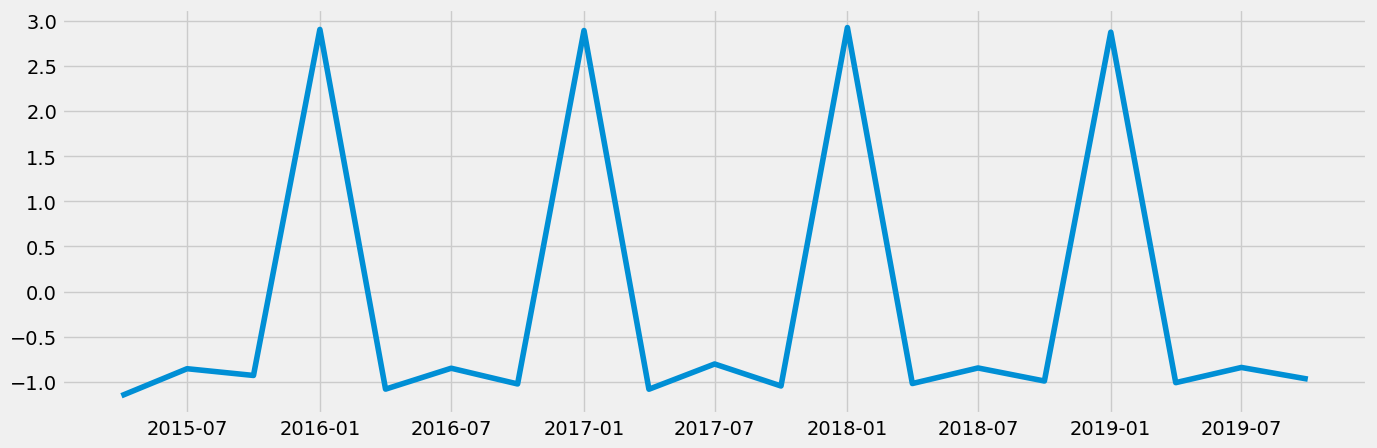

In [23]:
# Check what the differencing did to the time-series curve

plt.figure(figsize = (15,5), dpi = 100)
plt.plot(data_diff)

In [24]:
# Run the Dickey-Fuller test again checking for stationarity
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -1.081399
p-value                         0.722432
Number of Lags Used             4.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64


#### Both the test statistic and p-value became larger. Since it's still not smaller than the critical value (5%), another round of differencing will be run.

In [25]:
# Conduct a second round of differencing
# The df.shift(1) function turns the observation to t-1, making it t - (t-1)
data_diff_2 = data_diff - data_diff.shift(1)

In [26]:
# Remove the missing values from the results of differencing
# These must be removed or the Dickey-Fuller test cannot be run
data_diff_2.dropna(inplace = True)

In [27]:
data_diff_2.head()

,Happiness Score
,mean
Quarterly Date,
2015-07-01,0.299513
2015-10-01,-0.074739
2016-01-01,3.836400
2016-04-01,-3.988046
2016-07-01,0.231692


In [28]:
# Run the Dickey-Fuller test again checking for stationarity
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.262875
p-value                         0.000515
Number of Lags Used             3.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64


#### After a second round of differencing, the test statistic is now -4.262875 which is smaller than the critical value (5%) of -3.104184. The p-value is also much smaller than 0.05, making it now significant. With both values being changed, the null hypothesis can be rejected.

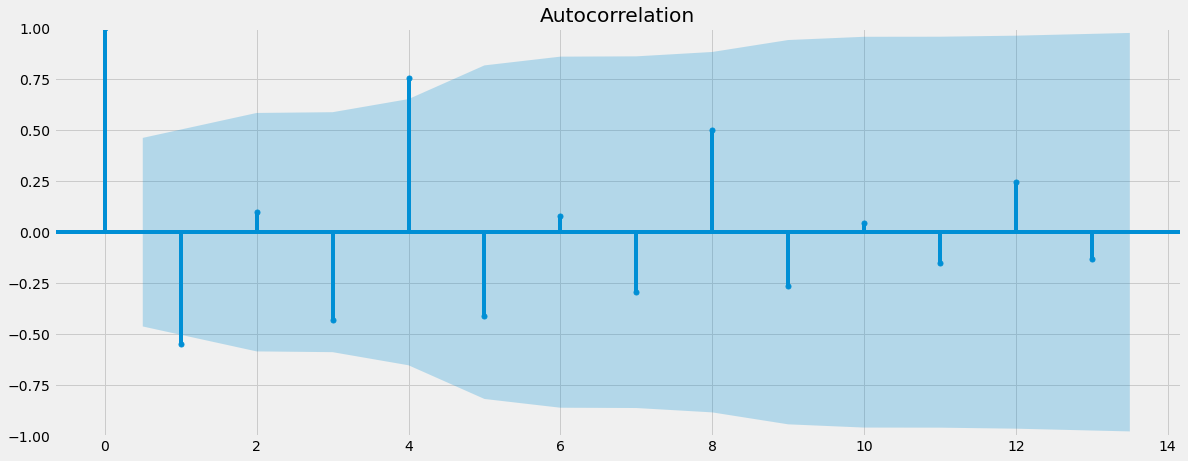

In [29]:
# Check the plot for autocorrelations again

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import the autocorrelation and partial correlation plots

plot_acf(data_diff_2)
plt.show()